# Ressources

In [60]:
import pandas as pd
import numpy as np
import missingno



# fix pour plotly express et Visual Studio Code
import plotly.io as pio
pio.renderers.default = "notebook_connected"

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer


from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import recall_score, accuracy_score,roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split


from tqdm import tqdm

# Garbage collection is to release memory when the object is no longer in use. This system destroys the unused object and reuses its memory slot for new objects. You can imagine this as a recycling system in computers.

import shap


from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, auc, plot_confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict

import gc

from rich.console import Console

from sklearn.metrics import confusion_matrix, classification_report

# Fonctions

In [61]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=RuntimeWarning)


#  https://www.kaggle.com/code/desalegngeb/heart-disease-predictions
def score_summary(names, classifiers, df):
    '''
    Given a list of classiers, this function calculates the accuracy, 
    ROC_AUC and Recall and returns the values in a dataframe
    
    
    Exemple ---
    
    >>> score_summary(names, classifiers).sort_values(by='Accuracy' , ascending = False)\
        
    >>> .style.background_gradient(cmap='coolwarm')\
        
    >>> .bar(subset=["ROC_AUC",], color='#6495ED')\
        
    >>> .bar(subset=["Recall"], color='#ff355d')\
        
    >>> .bar(subset=["Precision"], color='lightseagreen')\
        
    >>> .bar(subset=["F1"], color='gold')
    '''
    
    X = df.drop(['TARGET'], axis=1)
    y = df['TARGET']
    
       
    imp = IterativeImputer(missing_values = np.nan, random_state=0)
        
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0, stratify=y)
    

    
    cols=["Classifier", "Accuracy", "ROC_AUC Test", "ROC_AUC Train", "Recall", "Precision", "F1"]
    data_table = pd.DataFrame(columns=cols)
    
    for name, clf in zip(names, classifiers):
        pipe = make_pipeline(imp,
                         StandardScaler(),
                         SMOTE(sampling_strategy=0.75, random_state=42),
                         clf)
                
        pipe.fit(X_train, y_train)
        
        pred = pipe.predict(X_test)
        accuracy = accuracy_score(y_test, pred)

        pred_proba_test = pipe.predict_proba(X_test)[:, 1]
        pred_proba_train = pipe.predict_proba(X_train)[:, 1]
        
        fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test)        
        # roc_auc = auc(fpr, tpr)
        
        roc_auc_test = roc_auc_score(y_test, pred_proba_test)
        roc_auc_train = roc_auc_score(y_train, pred_proba_train)
        
        # confusion matric, cm
        cm = confusion_matrix(y_test, pred) 
        
        # recall: TP/(TP+FN)
        recall = cm[1,1]/(cm[1,1] +cm[1,0])
        
        # precision: TP/(TP+FP)
        precision = cm[1,1]/(cm[1,1] +cm[0,1])
        
        # F1 score: TP/(TP+FP)
        f1 = 2*recall*precision/(recall + precision)

        df = pd.DataFrame([[name, accuracy*100, roc_auc_test, roc_auc_train, recall, precision, f1]], columns=cols)
        data_table = data_table.append(df)     

    return data_table.reset_index(drop=True)



def roc_auc_curve(names, classifiers, df):
    '''
    Given a list of classifiers, this function plots the ROC curves
    
    '''
    
    X = df.drop(['TARGET'], axis=1)
    y = df['TARGET']
    
       
    imp = IterativeImputer(missing_values = np.nan, random_state=0)
        
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0, stratify=y)
           
    plt.figure(figsize=(12, 8))   
        
    for name, clf in zip(names, classifiers):
        pipe = make_pipeline(imp,
                         StandardScaler(),
                         SMOTE(sampling_strategy=0.75, random_state=42),
                         clf)        
        pipe.fit(X_train, y_train)
        
        pred_proba = pipe.predict_proba(X_test)[:, 1]
        
        fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
        roc_auc = roc_auc_score(y_test, pred_proba)
        
        plt.plot(fpr, tpr, lw=3, label= name +' ROC curve (area = %0.2f)' % (roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC) curves', fontsize=20)
        plt.legend(loc="lower right")
        
        
        
def plot_conf_matrix(names, classifiers, df, nrows, ncols, fig_a, fig_b):
    '''
    Plots confusion matrices in a subplots.
    
    Args:
        names : list of names of the classifier
        classifiers : list of classification algorithms
        nrows, ncols : number of rows and rows in the subplots
        fig_a, fig_b : dimensions of the figure size
    '''
    
    X = df.drop(['TARGET'], axis=1)
    y = df['TARGET']
    
       
    imp = IterativeImputer(missing_values = np.nan, random_state=0)
        
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0, stratify=y)
       
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_a, fig_b))
    
    i = 0
    for clf, ax in zip(classifiers, axes.flatten()):
        
        pipe = make_pipeline(imp,
                         StandardScaler(),
                         clf)        
        pipe.fit(X_train, y_train)
        plot_confusion_matrix(pipe, X_test, y_test, ax=ax)
        ax.title.set_text(names[i])
        i = i + 1       
        
    plt.tight_layout() 
    plt.show()

# Data

In [62]:
data_results = pd.read_csv('data_kernel_clean.csv')
data_results

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356246,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356247,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356248,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356249,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
df_importance = pd.read_csv('feature_importance/feature_importance_avg.csv')
df_importance

,feature,importance,importance_normalized,cumulative_importance
0,PAYMENT_RATE,1128.6,0.024368,0.024368
1,EXT_SOURCE_1,1005.5,0.021711,0.046079
2,EXT_SOURCE_3,960.6,0.020741,0.066820
3,EXT_SOURCE_2,913.9,0.019733,0.086553
4,DAYS_BIRTH,718.4,0.015512,0.102064
...,...,...,...,...
789,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,0.0,0.000000,1.000000
790,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,0.0,0.000000,1.000000
791,POS_NAME_CONTRACT_STATUS_Demand_MEAN,0.0,0.000000,1.000000
792,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,0.0,0.000000,1.000000


## Selection Features

In [64]:
cols = df_importance.sort_values(by=["importance"], ascending=False)['feature'].unique()[:40]
data_features = data_results[cols]

data_features['SK_ID_CURR'] = data_results['SK_ID_CURR']
data_features['TARGET'] = data_results['TARGET']

# Pour l'API
data_features.to_csv('api/data_api.csv', index=False)

data_features



# ---------------

# from sklearn.feature_selection import SelectFromModel

# selector = SelectFromModel(LGBMClassifier(random_state=42), max_features=20).fit(data_results.drop("TARGET", axis=1), data_results['TARGET'])
# columns = selector.get_feature_names_out().tolist()
# display(f"Colonnes retenues : {columns}")

# columns.append('TARGET')

# data_features = data_results[columns]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,PAYMENT_RATE,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,AMT_ANNUITY,DAYS_EMPLOYED,APPROVED_CNT_PAYMENT_MEAN,DAYS_ID_PUBLISH,INCOME_CREDIT_PERC,...,BURO_DAYS_CREDIT_ENDDATE_MAX,INSTAL_AMT_PAYMENT_MIN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_MEAN,INSTAL_DBD_MAX,CLOSED_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_DEBT_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,SK_ID_CURR,TARGET
0,0.060749,0.083037,0.139376,0.262949,9461,24700.5,-637.0,24.000000,-2120,0.121978,...,780.0,9251.775,780.0,-572.5,31.0,63844.500000,49156.200,780.0,100002,1.0
1,0.027598,0.311267,NaN,0.622246,16765,35698.5,-1188.0,10.000000,-291,0.132217,...,1216.0,6662.970,1216.0,-606.0,14.0,69133.500000,0.000,1216.0,100003,0.0
2,0.050000,NaN,0.729567,0.555912,19046,6750.0,-225.0,4.000000,-2531,0.100000,...,-382.0,5357.250,NaN,NaN,11.0,94518.900000,0.000,NaN,100004,0.0
3,0.094941,NaN,NaN,0.650442,19005,29686.5,-3039.0,18.000000,-2437,0.219900,...,NaN,2482.920,NaN,NaN,77.0,NaN,NaN,NaN,100006,0.0
4,0.042623,NaN,NaN,0.322738,19932,21865.5,-3038.0,20.666667,-3458,0.179963,...,-783.0,0.180,NaN,NaN,31.0,146250.000000,0.000,NaN,100007,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356246,0.042354,NaN,0.643026,0.648575,19970,17473.5,-5169.0,24.000000,-3399,0.143815,...,793.0,14222.430,793.0,-452.0,8.0,93622.500000,111294.000,644.0,456221,NaN
356247,0.051267,NaN,NaN,0.684596,11186,31909.5,-1149.0,17.500000,-3003,0.202600,...,NaN,2.700,NaN,NaN,26.0,NaN,NaN,NaN,456222,NaN
356248,0.105414,0.733503,0.283712,0.632770,15922,33205.5,-3037.0,11.000000,-1504,0.163978,...,-13.0,12640.950,NaN,-229.0,76.0,526440.375000,4268.700,NaN,456223,NaN
356249,0.055840,0.373090,0.595456,0.445701,13968,25128.0,-2731.0,17.000000,-1364,0.111680,...,980.0,5519.925,980.0,-1077.5,15.0,152999.566364,52511.904,652.2,456224,NaN


## Modification de features

In [65]:
# def positive_nombre(x):
#     if type(x) == int or type(x) == float:
#         if x < 0:
#             x = x * (-1) 
#     return x

# # Certaines colonnes seront plus lisibles en étant positive
# for col in ['DAYS_EMPLOYED', 'DAYS_ID_PUBLISH']:
#     data_features[col] = data_features[col].apply(positive_nombre)
    
# # pour plus de lisibilité, on va changer les jours en mois

# for col in ['DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED']:
#     data_features[col] = np.ceil(data_features[col] / 30)
    
# data_features.rename(columns={'DAYS_BIRTH' : 'MONTHS_BIRTH',
#                       'DAYS_ID_PUBLISH' : 'MONTH_ID_PUBLISH',
#                       'DAYS_EMPLOYED' : 'MONTH_EMPLOYED'}, inplace=True )


# Après différents tests, ce seront des modifications qu'on effectuera au niveau du dashboard.
# La raison est que ces modifications rendent les données moins "précises" et donnent des résultats moins satisfaisants au niveau des algorithmes.
# En moyenne, cela n'impactait pas les Faux Negatives / True positive, en revanche, ça augmentait de 5000 les Faux positifs

In [66]:
data_features

,PAYMENT_RATE,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,AMT_ANNUITY,DAYS_EMPLOYED,APPROVED_CNT_PAYMENT_MEAN,DAYS_ID_PUBLISH,INCOME_CREDIT_PERC,...,BURO_DAYS_CREDIT_ENDDATE_MAX,INSTAL_AMT_PAYMENT_MIN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_MEAN,INSTAL_DBD_MAX,CLOSED_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_DEBT_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,SK_ID_CURR,TARGET
0,0.060749,0.083037,0.139376,0.262949,9461,24700.5,-637.0,24.000000,-2120,0.121978,...,780.0,9251.775,780.0,-572.5,31.0,63844.500000,49156.200,780.0,100002,1.0
1,0.027598,0.311267,NaN,0.622246,16765,35698.5,-1188.0,10.000000,-291,0.132217,...,1216.0,6662.970,1216.0,-606.0,14.0,69133.500000,0.000,1216.0,100003,0.0
2,0.050000,NaN,0.729567,0.555912,19046,6750.0,-225.0,4.000000,-2531,0.100000,...,-382.0,5357.250,NaN,NaN,11.0,94518.900000,0.000,NaN,100004,0.0
3,0.094941,NaN,NaN,0.650442,19005,29686.5,-3039.0,18.000000,-2437,0.219900,...,NaN,2482.920,NaN,NaN,77.0,NaN,NaN,NaN,100006,0.0
4,0.042623,NaN,NaN,0.322738,19932,21865.5,-3038.0,20.666667,-3458,0.179963,...,-783.0,0.180,NaN,NaN,31.0,146250.000000,0.000,NaN,100007,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356246,0.042354,NaN,0.643026,0.648575,19970,17473.5,-5169.0,24.000000,-3399,0.143815,...,793.0,14222.430,793.0,-452.0,8.0,93622.500000,111294.000,644.0,456221,NaN
356247,0.051267,NaN,NaN,0.684596,11186,31909.5,-1149.0,17.500000,-3003,0.202600,...,NaN,2.700,NaN,NaN,26.0,NaN,NaN,NaN,456222,NaN
356248,0.105414,0.733503,0.283712,0.632770,15922,33205.5,-3037.0,11.000000,-1504,0.163978,...,-13.0,12640.950,NaN,-229.0,76.0,526440.375000,4268.700,NaN,456223,NaN
356249,0.055840,0.373090,0.595456,0.445701,13968,25128.0,-2731.0,17.000000,-1364,0.111680,...,980.0,5519.925,980.0,-1077.5,15.0,152999.566364,52511.904,652.2,456224,NaN


In [67]:
data_features_train = data_features[data_features['TARGET'].notnull()] # Target présent
data_features_train.drop(['SK_ID_CURR'], axis=1, inplace=True)
data_features_test = data_features[data_features['TARGET'].isnull()] # Target NA

print(f"Train : {data_features_train.shape}")
print(f"Test : {data_features_test.shape}")

feat = [f for f in data_features_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']] # variables du DF qui ne sont pas dans la liste (Target est la variable à prédire, les autres n'ont pas d'impact sur la prédiction)

data_features_train.to_csv('data_feature_selected_train.csv', index=False)
data_features_test.to_csv('data_feature_selected_test.csv', index=False)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Train : (307507, 41)
Test : (48744, 42)


In [68]:
feat = [f for f in data_features_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']] # variables du DF qui ne sont pas dans la liste (Target est la variable à prédire, les autres n'ont pas d'impact sur la prédiction)

# Test

Préparation

In [69]:
clf = LGBMClassifier(
            # nthread=8,
            n_estimators=10000,
            learning_rate=0.02,
            metric="auc",
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,
            device="cpu",
            n_jobs=-1)

In [70]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

names =[
    'Catboost',
    'xgbbost',
    'lightGBM',
    'Random Forest',
    'LR',
    'Decision Tree',
    'LDA',
    'GradiantBoosting'
]

seed = 0

classifiers = [
    CatBoostClassifier(random_state=seed, verbose=0),
    XGBClassifier(objective= 'binary:logistic', random_state=seed),
    clf,
    RandomForestClassifier(random_state=seed),
    LogisticRegression(solver="liblinear", random_state=seed),
    DecisionTreeClassifier(random_state=seed),
    LinearDiscriminantAnalysis(),
    GradientBoostingClassifier(random_state=seed),
   ]

In [71]:
score_summary(names, classifiers, data_features_train).sort_values(by='ROC_AUC Test' , ascending = False)\
.style.background_gradient(cmap='coolwarm', text_color_threshold=0)\
.bar(subset=["ROC_AUC Test"], color='#6495ED')\
.bar(subset=["ROC_AUC Train"], color='#6495ED')\
.bar(subset=["Recall"], color='#ff355d')\
.bar(subset=["Precision"], color='lightseagreen')\
.bar(subset=["F1"], color='gold')


# ici, y a une différence claire au niveau de l'Accuracy

,Classifier,Accuracy,ROC_AUC Test,ROC_AUC Train,Recall,Precision,F1
2,lightGBM,91.533067,0.749213,0.980652,0.075054,0.377448,0.125210
0,Catboost,91.646884,0.746679,0.841128,0.058405,0.385638,0.101446
4,LR,76.472310,0.744128,0.745463,0.567132,0.186038,0.280171
6,LDA,76.317301,0.741761,0.743622,0.562701,0.183961,0.277274
1,xgbbost,90.716833,0.719652,0.801418,0.090494,0.273539,0.135997
3,Random Forest,88.507691,0.714885,1.000000,0.176155,0.227068,0.198397
7,GradiantBoosting,82.620619,0.702585,0.709653,0.338883,0.185139,0.239457
5,Decision Tree,77.292879,0.555738,1.000000,0.296724,0.123326,0.174235


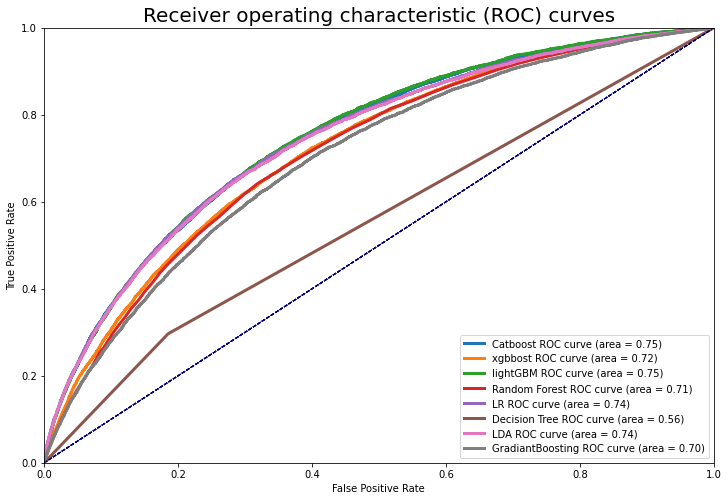

In [72]:
roc_auc_curve(names, classifiers, data_features_train)

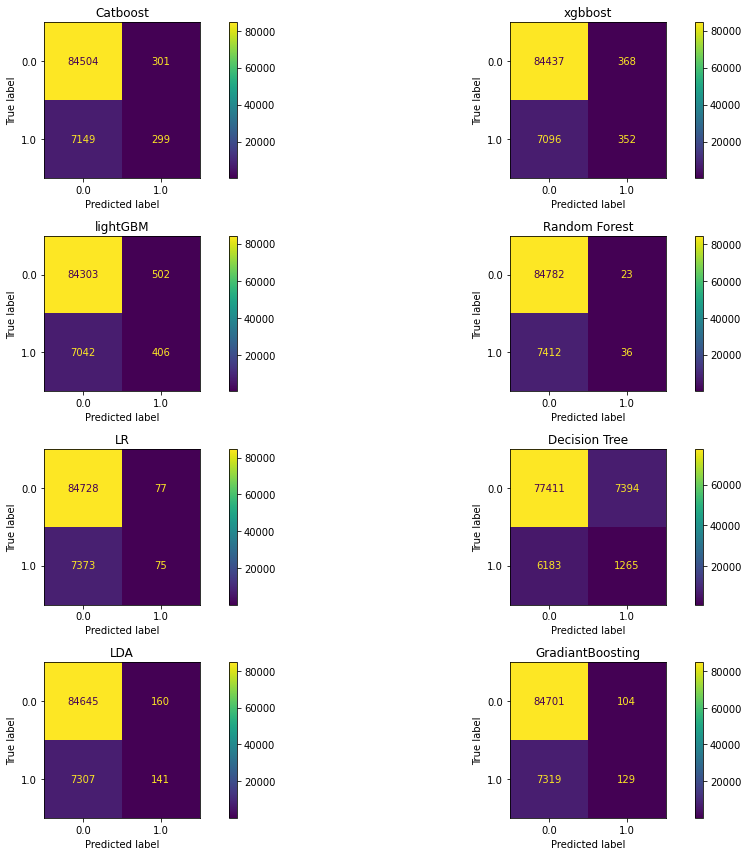

In [73]:
plot_conf_matrix(names, classifiers, data_features_train, nrows=4, ncols=2, fig_a=15, fig_b=12)